You present your wind turbine solution to management, but they complain that your solution cannot work in practice—it requires one of the factories to produce many more wind turbines than is realistic. Revise your model so that it will enforce production capacities.
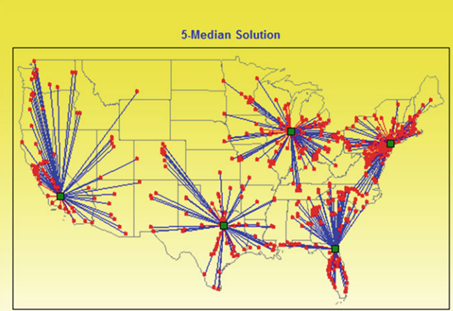

In [1]:
fac = list(range(100))   # candidate factory locations
dem = list(range(1000))  # demand points

In [2]:
# For convenience, pick the (annual) factory costs at random
import random
fac_cost = [ 30000 * random.random() for i in fac ]

# pick uniform supply/capacity of 1,000
supply = [ 1000 for i in fac ]

# pick uniform demand of 5
demand = [ 5 for j in dem ]

In [3]:
# For convenience, pick the factory locations at random
fac_x = [ random.random() for i in fac ]
fac_y = [ random.random() for i in fac ]

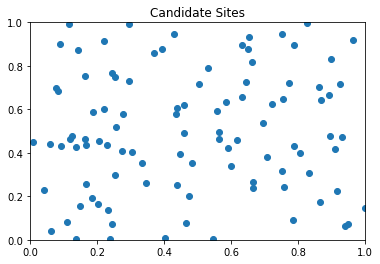

In [4]:
# Draw the factory locations
import matplotlib.pyplot as plt

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(fac_x, fac_y)
plt.title('Candidate Sites')
plt.show()

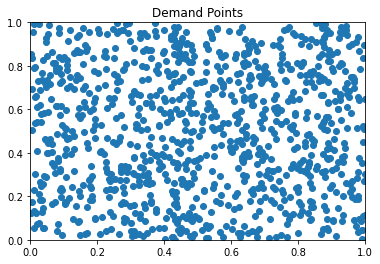

In [5]:
# Draw the demand point locations
dem_x = [ random.random() for i in dem ]
dem_y = [ random.random() for i in dem ]

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(dem_x, dem_y)
plt.title('Demand Points')
plt.show()

In [6]:
# Suppose that cost equals rectilinear distance
def rect_dist(x1,y1,x2,y2):
    return abs(x1-x2) + abs(y1-y2)

cost = { (i,j) : rect_dist( fac_x[i], fac_y[i], dem_x[j], dem_y[j] ) for i in fac for j in dem }

In [7]:
# # Suppose that cost equals Chebyshev distance
# def cheb_dist(x1,y1,x2,y2):
#     return max( abs(x1-x2), abs(y1-y2) )

# cost = { (i,j) : cheb_dist( fac_x[i], fac_y[i], dem_x[j], dem_y[j] ) for i in fac for j in dem }

In [8]:
# # Suppose that cost equals Euclidean distance
# import math
# def eucl_dist(x1,y1,x2,y2):
#     return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

# cost = { (i,j) : eucl_dist( fac_x[i], fac_y[i], dem_x[j], dem_y[j] ) for i in fac for j in dem }

In [9]:
import gurobipy as gp
from gurobipy import GRB

In [10]:
# create model 
m = gp.Model()

# create variables, x[i,j] = number of units that demand point j receives from factory i
x = m.addVars(fac, dem, vtype=GRB.INTEGER)

# create variables, y[i] = 1 if locate a facility at site i
y = m.addVars(fac, vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [11]:
# Objective: minimize transportation cost (annual) + factory cost (annual)
m.setObjective( gp.quicksum( cost[i,j] * x[i,j] for i in fac for j in dem) 
               + gp.quicksum( fac_cost[i] * y[i] for i in fac), GRB.MINIMIZE )

In [12]:
# Constraints: each demand point should receive its full demand
m.addConstrs( gp.quicksum( x[i,j] for i in fac ) == demand[j] for j in dem )

# Constraints: if no factory is built at site i, it can serve no demand point
m.addConstrs( gp.quicksum( x[i,j] for j in dem ) <= supply[i] * y[i] for i in fac )

# Optional strengthening constraints
#m.addConstrs( x[i,j] <= demand[j] * y[i] for i in fac for j in dem )

m.update()

In [13]:
# force Gurobi to use concurrent method (primal simplex, dual simplex, barrier all at the same time!)
m.Params.Method = 3

# solve
m.optimize()

Set parameter Method to value 3
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1100 rows, 100100 columns and 200100 nonzeros
Model fingerprint: 0x219a6485
Variable types: 0 continuous, 100100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-03, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 1504255.8485
Presolve time: 0.20s
Presolved: 1100 rows, 100100 columns, 200100 nonzeros
Variable types: 0 continuous, 100100 integer (100 binary)
Found heuristic solution: objective 1503964.6331

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+05
 Factor NZ  : 1.215e+05 (roughly 40 MB of memory)
 Factor Ops : 1.416e+07 (less than 1 second per iteration)
 Threads    : 

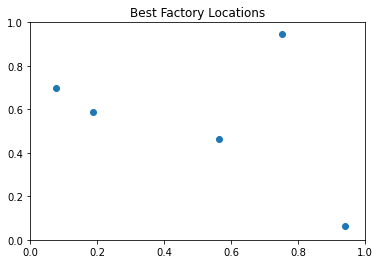

In [14]:
medians = [ i for i in fac if y[i].x > 0.5 ]
medians_x = [ fac_x[i] for i in medians ]
medians_y = [ fac_y[i] for i in medians ]

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(medians_x, medians_y)
plt.title('Best Factory Locations')
plt.show()

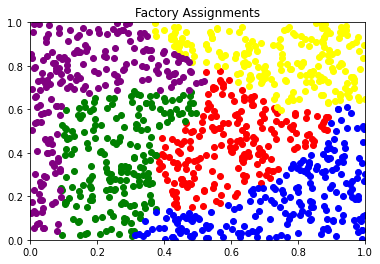

In [15]:
# Draw the factory assignments
pallette = ['red', 'yellow', 'green', 'blue', 'purple']

k = len(medians)
for p in range(k):
    i = medians[p]
    assigned = [ j for j in dem if x[i,j].x > 0.5 ]
    assigned_x = [ dem_x[j] for j in assigned ]
    assigned_y = [ dem_y[j] for j in assigned ]
    plt.scatter(assigned_x, assigned_y, color=pallette[p])

plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Factory Assignments')
plt.show()